# Quality Prediction Model

This messy notebook trains the XGboost model used in wikidit.

In [1]:
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2
import wikidit

In [2]:
from wikidit.preprocessing import _load_backlog, WP10_LABELS
from wikidit.io import read_labeled
from wikidit.ordinal import SequentialClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import (f1_score, roc_auc_score, accuracy_score, 
                             precision_score, recall_score, log_loss, 
                             confusion_matrix)
from sklearn.base import clone

In [3]:
import xgboost

In [4]:
xgboost.__version__

'0.80'

# Train Model

In [5]:
output_dir = "../data/enwiki-labeling_revisions-w_features/"
revisions = read_labeled(output_dir)

In [6]:
revisions.head()

,anon,backlog_accuracy,backlog_accuracy_templates,backlog_content,backlog_content_templates,backlog_files,backlog_files_templates,backlog_links,backlog_links_templates,backlog_other,...,templates,templates_per_word,timestamp,title,user,userid,wikilinks,wikilinks_per_word,words,wp10
0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,266,0.056059,2015-04-25T23:51:42Z,Astatine,GermanJoe,12935443,221,0.046575,4745,FA
1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,54,0.003383,2011-03-27T00:14:12Z,"John, King of England",GimmeBot,3188459,514,0.032197,15964,FA
2,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,115,0.023829,2015-10-19T02:51:50Z,Maniac Mansion,JimmyBlackwing,490055,285,0.059055,4826,FA
3,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,259,0.032086,2010-12-20T05:10:11Z,Speed of light,GimmeBot,3188459,489,0.060580,8072,FA
4,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,191,0.023259,2012-01-18T04:42:08Z,Psilocybin,GimmeBot,3188459,523,0.063687,8212,FA


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from wikidit.models import RevisionPreprocessor

In [9]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
import xgboost as xgb
import dill
import itertools

response_col = ['wp10']

xgb_params = {
  'silent': True,
  'booster': 'gbtree',
  'objective': 'binary:logistic',
  'random_state': 12345,
  'learning_rate': 0.1,
  'n_estimators': 100,
  'min_child_weight': 1,
  'gamma': 0,
  'subsample': 1,
  'colsample_bytree': 1,
  'max_depth': 3,
  'nthread': 4
}

clf = xgb.XGBClassifier(**xgb_params)

X = RevisionPreprocessor().fit_transform(revisions)
y = revisions['wp10'].values.codes

# Parameter Tuning

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, stratify=y)

In [11]:
from scipy.stats.distributions import randint

rnd_search_pars = {'n_iter': 10, 'n_jobs': 4, 'cv': 5}

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.05, 0.2],
    'min_child_weight': randint(1, 5),
    'gamma': [0, 0.125, 0.25, 0.5, 1, 2],
    'subsample': [0.8, 0.9, 0.95, 0.99, 1],
    'colsample_bytree': [0.8, 0.9, 0.95, 0.99, 1],
    'max_depth': randint(2, 8)
}

rnd_search = RandomizedSearchCV(clf, xgb_param_grid, scoring='neg_log_loss',
                                random_state=1234,
                                **rnd_search_pars)
rnd_results = rnd_search.fit(X_train, y_train)

In [12]:
rnd_search

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=12345, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=4,
          param_distributions={'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.05, 0.2], 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12012f470>, 'gamma': [0, 0.125, 0.25, 0.5, 1, 2], 'subsample': [0.8, 0.9, 0.95, 0.99, 1], 'colsample_bytree': [0.8, 0.9, 0.95, 0.99, 1], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12012f5c0>},
          pre_dispatch='2*n_jobs', random_state=1234, refit=True,
          r

In [13]:
y_pred = rnd_results.predict(X_test)
prob_pred = rnd_results.predict_proba(X_test)

To account for the accuracy, average the number of correct binary classifications each observation, then average over all observations.

In [82]:
from sklearn.preprocessing import LabelBinarizer

In [128]:
y_pred_onehot = LabelBinarizer().fit_transform(y_pred)
y_test_onehot = LabelBinarizer().fit_transform(y_test)

In [129]:
correct = y_pred_onehot == y_test_onehot
correct_ord = y_pred_onehot.cumsum(axis=1) == y_test_onehot.cumsum(axis=1)

In [195]:
correct_ord[1:].mean()

0.9180546987456303

In [194]:
correct.mean()

0.8719095348239527

In [196]:
recall_ord = np.zeros(6)
for i in range(6):
    recall_ord[i] = correct_ord[y_test == i, 1:].mean()
print(recall_ord)
recall_ord[1:].mean()

[0.99872495 0.93479452 0.86308113 0.83500456 0.90409463 0.93933934]


0.8952628359222216

In [140]:
recall = np.zeros(6)
for i in range(6):
    recall[i] = correct[y_test == i, i].mean()
print(recall)
recall.mean()

[0.84608379 0.63561644 0.4721969  0.37556974 0.61510464 0.76276276]


0.6178890444481301

In [149]:
precision_ord = np.zeros(6)
for i in range(6):
    precision_ord[i] = correct_ord[y_pred == i, 1:].mean()
print(precision_ord)
precision_ord[1:].mean()

[0.994      0.91391162 0.88199234 0.87185185 0.88576214 0.91497758]


0.8936991063680277

In [144]:
precision = np.zeros(6)
for i in range(6):
    precision[i] = correct[y_pred == i, i].mean()
print(precision)
precision.mean()

[0.84454545 0.5695581  0.49616858 0.50864198 0.56616415 0.68340807]


0.6114143899258837

The $F1$ score

In [147]:
2 * (precision_ord[1:].mean() * recall_ord[1:].mean()) / (precision_ord[1:].mean() + recall_ord[1:].mean())

0.9071417474558915

In [148]:
2 * (precision.mean() * recall.mean()) / (precision.mean() + recall.mean())

0.6146346664125559

In [117]:
pd.DataFrame(
    {'n': np.bincount(y_test),
     'precision': precision,
     'precision_exact': precision_exact,
     'recall': recall,
     'recall_exact': recall_exact
    })

,n,precision,precision_exact,recall,recall_exact
0,1098,0.969091,0.844545,0.973285,0.846084
1,1095,0.906028,0.702946,0.922983,0.771689
2,1097,0.900862,0.655172,0.883774,0.680036
3,1097,0.893004,0.844444,0.861744,0.756609
4,1099,0.904802,0.848409,0.919624,0.768881
5,999,0.929148,1.000000,0.949449,1.000000


In [114]:
predictions = pd.DataFrame({'actual': y_test, 'pred': y_pred})
for c in ('actual', 'pred'):
    predictions[c] = pd.Categorical.from_codes(predictions[c], WP10_LABELS)

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

In [154]:
confusion = predictions.groupby(['actual', 'pred']).aggregate(len).reset_index()
confusion = confusion.rename(columns={0: 'n'})
confusion['p'] = confusion['n'] / confusion['n'].sum()
actual_totals = confusion.groupby(['actual'])['n'].transform('sum')
confusion['p_actual'] = confusion['n'] / actual_totals

In [172]:
confusion_table = confusion.pivot(index='actual', columns='pred', values='p_actual').fillna(0)

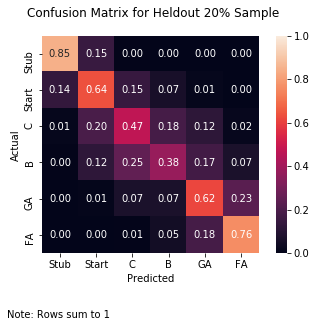

In [193]:
sns.heatmap(confusion_table, vmin=0, vmax=1, square=True, annot=True, fmt="0.2f")
plt.suptitle("Confusion Matrix for Heldout 20% Sample")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.figtext(0.4, -0.1, 'Note: Rows sum to 1', wrap=True, horizontalalignment='right')
plt.savefig('confusion-matrix.png')
plt.show()

# Fit Final model

In [59]:
pipeline = Pipeline([('preprocessor', RevisionPreprocessor()), ('clf', clone(rnd_results.best_estimator_))])

In [60]:
pipeline.fit(revisions, y)

Pipeline(memory=None,
     steps=[('preprocessor', RevisionPreprocessor()), ('clf', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.125, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=4, objective='multi:softprob',
       random_state=12345, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8))])

In [61]:
with open("../wikidit/xgboost-sequential.pkl", "wb") as f:
    dill.dump(pipeline, f)

# Tree of the Ordinal Model

Graphic of the tree of the ordinal model used in training.

In [198]:
from graphviz import Digraph

In [204]:
dot = Digraph(format='png')
dot.node('root', "P(c > Stub)")
dot.node('stub', 'P(Stub)', shape="rectangle")
dot.node('gtstub', "P(c > Start | c > Stub)")
dot.node('start', "P(Start)", shape="rectangle")
dot.node('gtstart', "P(c > Start | c > Stub)", )
dot.node('c', 'P(C)', shape="rectangle")
dot.node('gtc', "P(c > C | c > Start)")
dot.node('b', 'P(B)', shape="rectangle")
dot.node('gtb', "P(c > GA | c > B)")
dot.node('ga', 'P(GA)', shape="rectangle")
dot.node('fa', 'P(FA)', shape="rectangle")
dot.edge("root", "stub", label="")
dot.edge("root", "gtstub", label="")
dot.edge('gtstub', 'start', label="")
dot.edge('gtstub', 'gtstart', label="")
dot.edge('gtstart', 'c', label="")
dot.edge('gtstart', 'gtc', label="")
dot.edge('gtc', 'b', label="")
dot.edge('gtc', 'gtb', label="")
dot.edge('gtb', 'ga', label="")
dot.edge('gtb', 'fa', label="")
print(dot.source)

digraph {
	root [label="P(c > Stub)"]
	stub [label="P(Stub)" shape=rectangle]
	gtstub [label="P(c > Start | c > Stub)"]
	start [label="P(Start)" shape=rectangle]
	gtstart [label=""]
	c [label="P(C)" shape=rectangle]
	gtc [label=""]
	b [label="P(B)" shape=rectangle]
	gtb [label=""]
	ga [label="P(GA)" shape=rectangle]
	fa [label="P(FA)" shape=rectangle]
	root -> stub [label=""]
	root -> gtstub [label=""]
	gtstub -> start [label=""]
	gtstub -> gtstart [label=""]
	gtstart -> c [label=""]
	gtstart -> gtc [label=""]
	gtc -> b [label=""]
	gtc -> gtb [label=""]
	gtb -> ga [label=""]
	gtb -> fa [label=""]
}


In [205]:
dot.render('model.gv', view=True)

'model.gv.png'

# Information on Training Set

In [ ]:
revisions.groupby('wp10')['wp10'].count()

# Check one page

In [62]:
from wikidit.mw import get_page, Session

In [84]:
session = Session()
page = get_page("xgboost")

In [85]:
from wikidit.preprocessing import Featurizer
featurizer = Featurizer()

In [86]:
featurized = featurizer.featurize(page)

In [87]:
from wikidit.models import predict_page_edits

In [88]:
import dill
with open("../models/xgboost-sequential.pkl", "rb") as f:
    MODEL = dill.load(f) 

In [89]:
edits = predict_page_edits(page['content'], featurizer, MODEL)

In [98]:
for k, __, data in edits['edits']:
    if k in ('paragraph', 'images', 'ref'):
        print(k)
        print(data[['words', 'images', 'ref']])

for k, __, data in edits['edit_scores']:
    if k in ('paragraph', 'images', 'ref'):
        print(k, np.round(data, 2))

paragraph
   words  images  ref
0    466       0   14
images
   words  images  ref
0    316       1   14
ref
   words  images  ref
0    331       0   15
paragraph 1.85
images 1.67
ref 1.53


In [99]:
np.round(edits['score'], 2)

1.4